In [1]:
import os
import sys
import numpy as np
from typing import Union, Optional

from torch_geometric.data import InMemoryDataset, Data
from torch import load, save, tensor
import torch 


from ase.io import read
from ase import Atoms

from sklearn.preprocessing import OneHotEncoder

# Add src folder to the sys.path
src_path = "../src"
sys.path.insert(0, src_path)

from oxides_ml.constants import ADSORBATE_ELEMS, METALS, OHE_ELEMENTS
from oxides_ml.graph_filters import H_filter, C_filter, fragment_filter, ase_adsorption_filter, is_ring
#from oxides_ml.graph import atoms_to_pyg
#from oxides_ml.node_featurizers import get_gcn, get_radical_atoms, get_atom_valence, adsorbate_node_featurizer, get_magnetization
from oxides_ml.graph_tools import graph_plotter

/home/tvanhout/miniconda3/envs/oxides_ML/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/tvanhout/miniconda3/envs/oxides_ML/lib/python3.11/site-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_St8optionalIN3c1017basic_string_viewIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/tvanhout/miniconda3/envs/oxides_ML/lib/python3.11/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/tvanhout/miniconda3/envs/oxides_ML/lib/python3.11/site-packages/torch_sparse/_spmm_cuda.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
def pyg_dataset_id(vasp_directory: str, 
                   graph_params: dict) -> str:
    """
    Return dataset identifier based on the graph conversion settings.
    
    Args:
        vasp_directory (str): Path to the directory containing VASP simulation files.
        graph_params (dict): Dictionary containing the information for the graph generation 
                             in the format:
                            {"structure": {"tolerance": float, "scaling_factor": float, "second_order": int},
                             "features": {"encoder": OneHotEncoder, "adsorbate": bool, "ring": bool, "aromatic": bool, "radical": bool, "valence": bool, "facet": bool}}
    Returns:
        dataset_id (str): PyG dataset identifier.
    """
    # Extract directory name as ID
    id = os.path.basename(os.path.abspath(vasp_directory))

    # Extract graph structure conversion params
    structure_params = graph_params["structure"]
    tolerance = str(structure_params["tolerance"]).replace(".", "")
    scaling_factor = str(structure_params["scaling_factor"]).replace(".", "")
    second_order_nn = str(structure_params["second_order"])
    
    # Extract node features parameters
    features_params = graph_params["features"]
    adsorbate = str(features_params["adsorbate"])
    radical = str(features_params["radical"])
    valence = str(features_params["valence"])
    gcn = str(features_params["gcn"])
    mag = str(features_params["magnetization"])
    target = graph_params["target"]
    
    # Generate dataset ID
    dataset_id = "{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
        id, target, tolerance, scaling_factor, second_order_nn, 
        adsorbate, radical, valence, gcn, mag
    )
    
    return dataset_id


In [3]:
"""
This module contains functions and classes for creating, manipulating and analyzying graphs
from ASE Atoms objects to PyG Data format.
"""

from itertools import product

from sklearn.preprocessing import OneHotEncoder
from torch_geometric.data import Data
import numpy as np
import torch 
from scipy.spatial import Voronoi
from ase import Atoms
from networkx import Graph, set_node_attributes, connected_components, get_node_attributes
 
from oxides_ml.constants import CORDERO

def get_voronoi_neighbourlist(atoms: Atoms, 
                              tol: float, 
                              scaling_factor: float, 
                              adsorbate_elems: list[str], 
                              mic=True) -> np.ndarray:
    """
    Get connectivity list from Voronoi analysis, considering periodic boundary conditions.
    Assumption: The surface does not contain elements present in the adsorbate.
    
    Args:
        atoms (Atoms): ASE Atoms object representing the adsorbate-material system.
        tol (float): tolerance for the distance between two atoms to be considered connected.
        scaling_factor (float): scaling factor for the covalent radii of the material atoms.
        adsorbate_elems (list[str]): list of elements present in the adsorbate.
        
    Returns:
        np.ndarray: connectivity list of the system. Each row represents a pair of connected atoms.

    Notes:
        Each connection is represented once, i.e. if atom A is connected to atom B, the pair (A, B) will be present in the list,
        but not the pair (B, A).
    """

    if len(atoms) == 0:
        return np.array([])
    num_adsorbate_atoms = len([atom for atom in atoms if atom.symbol in adsorbate_elems])
    
    # First necessary condition for two atoms to be linked: Sharing a Voronoi facet
    coords_arr = np.repeat(np.expand_dims(np.copy(atoms.get_scaled_positions()), axis=0), 27, axis=0)
    mirrors = np.repeat(np.expand_dims(np.asarray(list(product([-1, 0, 1], repeat=3))), 1), coords_arr.shape[1], axis=1)
    corrected_coords = np.reshape(coords_arr + mirrors, (coords_arr.shape[0] * coords_arr.shape[1], coords_arr.shape[2]))
    corrected_coords = np.dot(corrected_coords, atoms.get_cell())
    translator = np.tile(np.arange(coords_arr.shape[1]), coords_arr.shape[0])
    vor_bonds = Voronoi(corrected_coords)
    pairs_corr = translator[vor_bonds.ridge_points]
    pairs_corr = np.unique(np.sort(pairs_corr, axis=1), axis=0)
    pairs_corr = np.delete(pairs_corr, np.argwhere(pairs_corr[:, 0] == pairs_corr[:, 1]), axis=0)

    increment = 0
    while True:
        pairs = []
        for pair in pairs_corr:
            atom1, atom2 = atoms[pair[0]].symbol, atoms[pair[1]].symbol
            threshold = CORDERO[atom1] + CORDERO[atom2] + tol
            distance = atoms.get_distance(pair[0], pair[1], mic=mic)
            if atom1 in adsorbate_elems and atom2 not in adsorbate_elems:
                threshold += max(scaling_factor + increment - 1.0, 0) * CORDERO[atom2]
            if atom1 not in adsorbate_elems and atom2 in adsorbate_elems:
                threshold += max(scaling_factor + increment - 1.0, 0) * CORDERO[atom1]

            if distance <= threshold:
                pairs.append(pair)

        if num_adsorbate_atoms == 0:
            pairs = pairs_corr
            break
        else: 
            c1 = any(
                atoms[pair[0]].symbol in adsorbate_elems
                and atoms[pair[1]].symbol not in adsorbate_elems
                for pair in pairs
            )
            c2 = any(
                atoms[pair[0]].symbol not in adsorbate_elems
                and atoms[pair[1]].symbol in adsorbate_elems
                for pair in pairs
            )
            if (c1 or c2) or all(atoms[i].symbol in adsorbate_elems for i in range(len(atoms))):
                break
            else:
                increment += 0.2

    return np.sort(np.array(pairs), axis=1)

def detect_ts(atoms: Atoms,
              adsorbate_elems: list[str], 
              tol: float) -> tuple[int]:
    """
    Return indices of the adsorbate atoms involved in the bond-breaking/forming reaction.

    Args:
        atoms (Atoms): ASE Atoms object representing the transition state image.
        adsorbate_elems (list[str]): list of elements present in the adsorbate.
    Returns:
        tuple[int]: indices of the atoms of the adsorbate involved in the bond-breaking/forming.
    """
    adsorbate_idxs = {atom.index for atom in atoms if atom.symbol in adsorbate_elems}
    neighbourlist = get_voronoi_neighbourlist(atoms, tol, 1.0, adsorbate_elems)
    neighbourlist = [(pair[0], pair[1]) for pair in neighbourlist if (pair[0] in adsorbate_idxs) and (pair[1] in adsorbate_idxs)]    
    nx = Graph()
    nx.add_nodes_from(adsorbate_idxs)  # Fundamental to initialize nodes! e.g. single atom would be neglected as has no edges
    nx.add_edges_from(neighbourlist)
    components = list(connected_components(nx))
    if len(components) != 2:
        print(f"{atoms.get_chemical_formula(mode='metal')}: {len(components)} components instead of 2 in the TS {components}\n")
        return None
    else:
        dist_dict = {}
        for node1 in components[0]:
            for node2 in components[1]:
                dist_dict[(node1, node2)] = atoms.get_distance(node1, node2, mic=True)
        return min(dist_dict, key=dist_dict.get)

def atoms_to_nx(atoms: Atoms, 
                voronoi_tolerance: float, 
                scaling_factor: float,
                second_order: bool, 
                adsorbate_elems: list[str], 
                mode: str) -> Graph:
    """
    Convert ASE Atoms object to NetworkX graph, representing the adsorbate-surface system.

    Args:
        atoms (Atoms): ASE Atoms object representing the adsorbate-material system.
        voronoi_tolerance (float): tolerance for the distance between two atoms to be considered connected.
        scaling_factor (float): scaling factor for the covalent radii of the surface atoms.
        adsorbate_elems (list[str]): list of elements present in the adsorbate.
        mode (str): whether the graph is created for the TS or the reactant/product. Default to 'ts'.
                    In case of 'ts', the graph will include an edge feature representing the broken bond.
    Returns:
        Graph: NetworkX graph representing the adsorbate-material system.
    """
    
    # 1) Get adsorbate atoms and neighbours
    adsorbate_idxs = {atom.index for atom in atoms if atom.symbol in adsorbate_elems}
    neighbour_list = get_voronoi_neighbourlist(atoms, voronoi_tolerance, scaling_factor, adsorbate_elems)        

    # 2) Get surface atoms that are neighbours of the adsorbate
    surface_neighbours_idxs = {
        pair[1] if pair[0] in adsorbate_idxs else pair[0] 
        for pair in neighbour_list 
        if (pair[0] in adsorbate_idxs and pair[1] not in adsorbate_idxs) or 
           (pair[1] in adsorbate_idxs and pair[0] not in adsorbate_idxs)
    }

    if second_order:
        # 2.1) Get surface atoms that are neighbours of the adsorbate's surface neighbours
        surface_neighbours_idxs = surface_neighbours_idxs.union({
            pair[1] if pair[0] in surface_neighbours_idxs else pair[0] 
            for pair in neighbour_list 
            if (pair[0] in surface_neighbours_idxs and pair[1] not in adsorbate_idxs) or 
               (pair[1] in surface_neighbours_idxs and pair[0] not in adsorbate_idxs)
        })
    
    # ensemble_idxs = adsorbate_idxs.union(surface_neighbours_idxs)
    # 3) Construct graph with the atoms in the ensemble
    graph = Graph()
    graph.add_nodes_from(list(adsorbate_idxs.union(surface_neighbours_idxs)))
    set_node_attributes(graph, {i: atoms[i].symbol for i in graph.nodes()}, "elem")
    ensemble_neighbour_list = [pair for pair in neighbour_list if pair[0] in graph.nodes() and pair[1] in graph.nodes()]
    graph.add_edges_from(ensemble_neighbour_list, ts_edge=0)
    if mode == "ts":
        broken_bond_idxs = detect_ts(atoms, adsorbate_elems, 0.25)
        graph.add_edge(broken_bond_idxs[0], broken_bond_idxs[1], ts_edge=1)
        return graph, list(surface_neighbours_idxs), broken_bond_idxs
    else:
        return graph, list(surface_neighbours_idxs), None


def atoms_to_pyg(atoms: Atoms,
                calc_type: str,
                voronoi_tol: float,
                scaling_factor: float,
                second_order: bool,
                one_hot_encoder: OneHotEncoder, 
                adsorbate_elems: list[str]=["C", "H", "O", "N", "S"]) -> Data:
    """
    Convert ASE Atoms object to PyG Data object, representing the adsorbate-surface system.   

    Args:
        atoms (Atoms): ASE Atoms object.
        calc_type (str): type of calculation performed on the system.
                         "int": intermediate, "ts": transition state.                         
        voronoi_tol (float): Tolerance applied during the graph conversion.
        scaling_factor (float): Scaling factor applied to atomic radius of materials.
        one_hot_encoder (OneHotEncoder): One-hot encoder.
        adsorbate_elems (list[str]): list of elements present in the adsorbate.
    Returns:
        graph (torch_geometric.data.Data): graph representation of the transition state.

    Notes:
        The graph is constructed as follows:
        - Nodes: one-hot encoded elements of the adsorbate and the surface atoms in contact with it.
        - Edges: connectivity list of the adsorbate-surface system.
        - Edge features: 1 if the edge corresponds to the broken bond in the TS, 0 otherwise.
    """
    if calc_type not in ["int", "ts"]:
        raise ValueError("calc_type must be either 'int' or 'ts'.")
    
    nx, surface_neighbors, bb_idxs = atoms_to_nx(atoms, voronoi_tol, scaling_factor, second_order, adsorbate_elems, calc_type)
    elem_list = list(get_node_attributes(nx, "elem").values())
    elem_array = np.array(elem_list).reshape(-1, 1)
    elem_enc = one_hot_encoder.transform(elem_array).toarray()
    x = torch.from_numpy(elem_enc).float()
    nodes_list = list(nx.nodes)
    edge_tails_heads = [(nodes_list.index(edge[0]), nodes_list.index(edge[1])) for edge in nx.edges]
    edge_tails = [x for x, _ in edge_tails_heads] + [y for _, y in edge_tails_heads]
    edge_heads = [y for _, y in edge_tails_heads] + [x for x, _ in edge_tails_heads]    
    edge_index = torch.tensor([edge_tails, edge_heads], dtype=torch.long)
    # edge attributes
    edge_attr = torch.zeros(edge_index.shape[1], 1)
    if calc_type == 'ts':
        for i in range(edge_index.shape[1]):
            edge_tuple = (nodes_list[edge_index[0, i].item()], nodes_list[edge_index[1, i].item()])
            if nx.edges[edge_tuple]['ts_edge'] == 1:
                edge_attr[i, 0] = 1  # As the nxgraph is undirected, the edge attribute is repeated twice
    return Data(x, edge_index, edge_attr, elem=elem_list), surface_neighbors, bb_idxs


In [ ]:
import os
import re

def get_parent_dir(path, levels=1):
    for _ in range(levels):
        path = os.path.dirname(path)
    return path

def extract_energy(outcar_path: str):
    """
    Extract total energy from VASP OUTCAR file.

    Args:
        outcar_path (str): Path to the OUTCAR file.

    Returns:
        float or None: Extracted total energy in eV, or None if not found.
    """
    try:
        with open(outcar_path, "r") as f:
            for line in f:
                if "free  energy   TOTEN" in line:
                    energy = float(line.split()[-2])  # Extract energy value
                    return energy
    except FileNotFoundError:
        print(f"OUTCAR file not found: {outcar_path}")
    except Exception as e:
        print(f"Error reading OUTCAR: {e}")
    
    return None


def extract_metadata(path: str):
    """
    Extract metadata based on the file path structure.

    Args:
        path (str): The file path of the CONTCAR/POSCAR file.

    Returns:
        dict: Metadata with 'material', 'adsorbate_group', and 'adsorbate_name'.
    """
    parts = path.split(os.sep)  # Split path into components
    
    metadata = {
        "material": None,
        "adsorbate_group": None,
        "adsorbate_name": None,
        "total_energy": None,
        "adsorbate_energy": None,
        "slab_energy": None,
        "adsorption_energy": None
    }

    if "gas_phase" in parts:
        metadata["adsorbate_group"] = parts[-3]
        metadata["adsorbate_name"] = parts[-2]      # Extract adsorbate name
        #metadata["adsorbate_energy"] = extract_energy((os.path.join(os.path.dirname(path), "OUTCAR")))
    elif "slab" in parts:
        metadata["material"] = parts[-2]            # Extract material name
        #metadata["slab_energy"] = extract_energy((os.path.join(os.path.dirname(path), "OUTCAR")))
    elif "surface_adsorbates":
        metadata["material"] = parts[-6]            # Extract material name
        metadata["adsorbate_group"] = parts[-5]     # Extract adsorbate group
        metadata["adsorbate_name"] = parts[-4]      # Extract adsorbate name
        metadata["total_energy"] = extract_energy((os.path.join(os.path.dirname(path), "OUTCAR")))
        #metadata["adsorbate_energy"] = extract_energy((os.path.join(get_parent_dir(path, 7), "gas_phase", metadata["adsorbate_group"], metadata["adsorbate_name"], "OUTCAR")))
        #metadata["slab_energy"] = extract_energy((os.path.join(get_parent_dir(path, 7), "slab", metadata["material"], "OUTCAR")))
    
    return metadata

In [16]:
path = os.path.join("/home/tvanhout/test_database/database/surface_adsorbates/IrO2/thiols_thials_thioketones_thioethers/Methanethiol/metal/conf_0/CONTCAR")
print(extract_energy((os.path.join(os.path.dirname(path), "OUTCAR"))))

-883.64256965


In [7]:
class OxidesGraphDataset(InMemoryDataset):

    def __init__(self,
             vasp_directory: str,  # Change input parameter
             graph_dataset_dir: str,
             graph_params: dict[str, Union[dict[str, bool | float], str]],  
             ncores: int=os.cpu_count(), 
             initial_state: bool=False):     
        self.dataset_id = pyg_dataset_id(vasp_directory, graph_params)
        self.vasp_directory = os.path.abspath(vasp_directory)
        self.root = self.vasp_directory

        self.graph_params = graph_params
        self.graph_structure_params = graph_params["structure"]
        self.node_feats_params = graph_params["features"]
        self.target = graph_params["target"]

        self.output_path = os.path.join(os.path.abspath(graph_dataset_dir), self.dataset_id)

        self.ncores = ncores
        ADSORBATE_ELEMENTS = ["C", "H", "N", "S"]
        self.adsorbate_elems = ADSORBATE_ELEMS
        self.elements_list = ADSORBATE_ELEMS + METALS
        self.ohe_elements = OHE_ELEMENTS

        self.node_feature_list = list(self.ohe_elements.categories_[0])
        self.node_dim = len(self.node_feature_list)
        for key, value in graph_params["features"].items():
            if value:
                self.node_dim += 1
                self.node_feature_list.append(key.upper())

        # Initialize InMemoryDataset
        super().__init__(root=os.path.abspath(graph_dataset_dir))
        if os.path.exists(self.processed_paths[0]):
            self.data, self.slices = load(self.processed_paths[0], weights_only=False)
        else:
            self.data, self.slices = None, None  # Prevent attribute errors

    @property
    def raw_file_names(self): 
        vasp_files = []
        for root, _, files in os.walk(self.vasp_directory):  # Recursively walk through directories
            for file in files:
                if file.startswith("CONTCAR"): #or file.startswith("POSCAR"):  
                    vasp_files.append(os.path.join(root, file))  # Store full path
        return vasp_files
        
    
    @property
    def processed_file_names(self): 
        return self.output_path
    
    def download(self):
        pass

    def process(self):
        """
        Process the VASP directory into PyG-compatible graphs using atoms_to_pyg.
        """
        vasp_files = self.raw_file_names

        # List to store graph data
        data_list = []
        
        for path in vasp_files:
            try:
                graph = self.atoms_to_data(path, self.graph_params)  # Convert to PyG graph
                if graph is not None:
                    data_list.append(graph)
            except Exception as e:
                print(f"Error processing {path}: {e}")

        # Isomorphism test: Removing duplicated data
        # print("Removing duplicated data ...")
        dataset = []
        for graph in data_list:
            if graph is not None:
                # is_duplicate, _ = self.is_duplicate(graph, dataset) 
                # if not is_duplicate:
                dataset.append(graph)
        print(f"Graph dataset size: {len(dataset)}")

        if len(dataset) == 0:
            print("No valid graphs found. Exiting process function.")
            return

        # Collate the data into the format required by PyG
        data, slices = self.collate(dataset)

        # Save the processed data
        save((data, slices), self.processed_paths[0])

    def is_duplicate(self, 
                    graph: Data, 
                    graph_list: list[Data], 
                    eps: float=0.01) -> tuple:
            """
            Perform isomorphism test for the input graph before including it in the final dataset.
            Test based on graph formula and energy difference.

            Args:
                graph (Data): Input graph.
                graph_list (list[Data]): graph list against which the input graph is tested.
                eps (float): tolerance value for the energy difference in eV. Default to 0.01 eV.
                grwph: data graph as input
            Returns:
                (bool): Whether the graph passed the isomorphism test.
            """
            if len(graph_list) == 0:
                return False, None
            else:
                for rival in graph_list:
                    if graph.type != rival.type:
                        continue
                    if graph.num_edges != rival.num_edges:
                        continue
                    if graph.num_nodes != rival.num_nodes:
                        continue
                    if graph.formula != rival.formula:
                        continue
                    if np.abs(graph.y - rival.y) > eps:
                        continue
                    if graph.facet != rival.facet:
                        continue
                    if graph.metal != rival.metal:
                        continue
                    # if graph.bb_type != rival.bb_type: # for TSs
                    #     continue
                    print("Isomorphism detected for {}".format(graph.formula))
                    return True, graph_list.index(rival)
                return False, None

    def atoms_to_data(self, structure: Union[Atoms, str], 
                    graph_params: dict[str, Union[float, int, bool]], 
                    model_elems: list[str] = ADSORBATE_ELEMS + METALS, 
                    calc_type: str='int', 
                    adsorbate_elements =ADSORBATE_ELEMS) -> Data:
        """
        Convert ASE objects to PyG graphs for inference.
        (target values are not included in the Data object).

        Args:
            structure (Atoms): ASE atoms object or POSCAR/CONTCAR file.
            graph_params (dict): Dictionary containing the information for the graph generation in the format:
                                {"tolerance": float, "scaling_factor": float, "metal_hops": int, "second_order_nn": bool}
            model_elems (list): List of chemical elements that can be processed by the model.
            calc_type (str): Type of calculation. "int" for intermediates, "ts" for transition states.
            adsorbate_elements (list): List of adsorbate elements. Default to ["C", "H", "O", "N", "S"].
        Returns:
            graph (Data): PyG Data object.
        """

        
        if isinstance(structure, str):
            path = structure  
            structure = read(structure)
        elif not isinstance(structure, Atoms):
            raise TypeError("Structure must be of type ASE Atoms or POSCAR/CONTCAR file path.")
        
        # Debug statement
        if not isinstance(structure, Atoms):
            print("Structure is not an ASE Atoms object.")
        
        # Get list of elements in the structure
        elements_list = list(set(structure.get_chemical_symbols()))
        if not all(elem in model_elems for elem in elements_list):
            raise ValueError("Not all chemical elements in the structure can be processed by the model.")
        
        # Read graph conversion parameters
        graph_structure_params = graph_params["structure"]
        graph_features_params = graph_params["features"]
        formula = structure.get_chemical_formula()

        # Construct one-hot encoder for elements
        ohe_elements = OneHotEncoder().fit(np.array(model_elems).reshape(-1, 1)) 
        elements_list = list(ohe_elements.categories_[0])
        node_features_list = list(ohe_elements.categories_[0]) 
        
        # append to node_features_list the key features whose value is True, in uppercase
        for key, value in graph_features_params.items():
            if value:
                node_features_list.append(key.upper())
        graph, surf_atoms, _ = atoms_to_pyg(structure, 
                                            calc_type,
                                            graph_structure_params["tolerance"], 
                                            graph_structure_params["scaling_factor"],
                                            graph_structure_params["second_order"], 
                                            ohe_elements, 
                                            adsorbate_elements)
        graph.type = calc_type    
        graph.formula = formula
        graph.node_feats = node_features_list

        metadata = extract_metadata(path)

        graph.material = metadata["material"]
        graph.adsorbate_group = metadata["adsorbate_group"]
        graph.adsorbate_name = metadata["adsorbate_name"]

        graph.facet = "110"
                
        graph.energy = metadata["total_energy"]
        graph.adsorbate_energy = metadata["adsorbate_energy"]
        graph.slab_energy = metadata["slab_energy"]
        graph.ads_energy = metadata["adsorption_energy"]

        # NODE FEATURIZATION
        # if graph_features_params["adsorbate"]:
        #     graph = adsorbate_node_featurizer(graph, adsorbate_elements)
        # if graph_features_params["radical"]:
        #     graph = get_radical_atoms(graph, adsorbate_elements)
        # if graph_features_params["valence"]:
        #     graph = get_atom_valence(graph, adsorbate_elements)
        # if graph_features_params["gcn"]:
        #     graph = get_gcn(graph, structure, adsorbate_elements, surf_atoms)
        # if graph_features_params["magnetization"]:
        #     graph = get_magnetization(graph)

        # for filter in [H_filter, C_filter, fragment_filter]:
        #     if not filter(graph, adsorbate_elements):
        #         return None 
        return graph
    
        # try:
        #     if graph_features_params["adsorbate"]:
        #         graph = adsorbate_node_featurizer(graph, adsorbate_elements)
        #     if graph_features_params["radical"]:
        #         graph = get_radical_atoms(graph, adsorbate_elements)
        #     if graph_features_params["valence"]:
        #         graph = get_atom_valence(graph, adsorbate_elements)
        #     if graph_features_params["gcn"]:
        #         graph = get_gcn(graph, structure, adsorbate_elements, surf_atoms)
        #     if graph_features_params["magnetization"]:
        #         graph = get_magnetization(graph)

        #     for filter in [H_filter, C_filter, fragment_filter]:
        #         if not filter(graph, adsorbate_elements):
        #             return None 
        #     return graph
        # except:
        #     print("Error in node featurization for {}\n".format(formula))
        #     return None

In [9]:
graph_params = {"structure": {"tolerance": 0.25, "scaling_factor": 1.25, "second_order": True},
                "features": {"adsorbate": False, "radical": False, "valence": False, "gcn": False, "magnetization": False},
                "target": "scaled_energy"}

vasp_directory = "/home/tvanhout/test_database/database"
graph_dataset_dir = "/home/tvanhout/test_database/graph_dataset"


dataset_id = pyg_dataset_id(vasp_directory, graph_params)
print(dataset_id)

database_scaled_energy_025_125_True_False_False_False_False_False


In [10]:
dataset = OxidesGraphDataset(vasp_directory, graph_dataset_dir, graph_params)
print(dataset)

OxidesGraphDataset(7)


In [11]:
for graph in range(len(dataset)):
    print(dataset[graph])

Data(x=[126, 7], edge_index=[2, 480], edge_attr=[480, 1], elem=[126], type='int', formula='CH4O80Ru40S', node_feats=[7], material='RuO2', adsorbate_group='thiols_thials_thioketones_thioethers', adsorbate_name='Methanethiol', facet='110', energy=[1])
Data(x=[126, 7], edge_index=[2, 482], edge_attr=[482, 1], elem=[126], type='int', formula='CH4O80Ru40S', node_feats=[7], material='RuO2', adsorbate_group='thiols_thials_thioketones_thioethers', adsorbate_name='Methanethiol', facet='110', energy=[1])
Data(x=[126, 7], edge_index=[2, 482], edge_attr=[482, 1], elem=[126], type='int', formula='CH4O80Ru40S', node_feats=[7], material='RuO2', adsorbate_group='thiols_thials_thioketones_thioethers', adsorbate_name='Methanethiol', facet='110', energy=[1])
Data(x=[126, 7], edge_index=[2, 478], edge_attr=[478, 1], elem=[126], type='int', formula='CH4Ir40O80S', node_feats=[7], material='IrO2', adsorbate_group='thiols_thials_thioketones_thioethers', adsorbate_name='Methanethiol', facet='110', energy=[1])


In [17]:
dataset[0].energy

tensor([-928.3377])

In [ ]:
dataset[0].elem

['Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'Ru',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'C',
 'H',
 'H',
 'H',
 'S',
 'H']

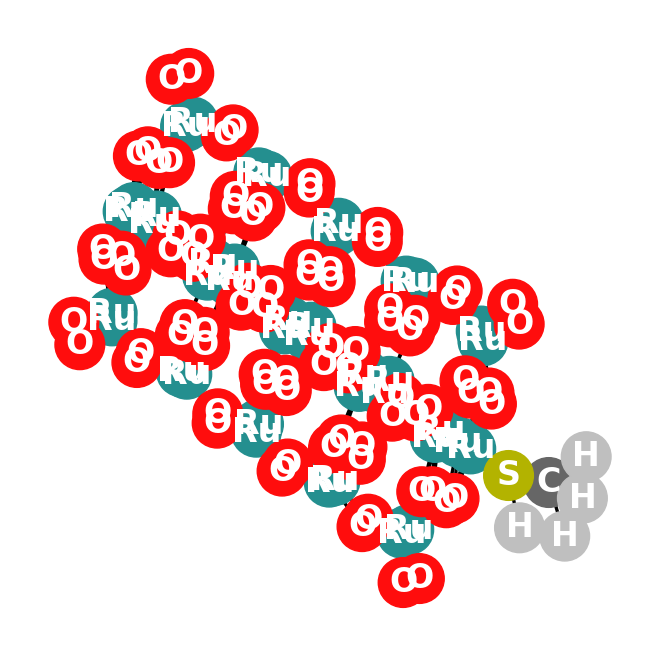

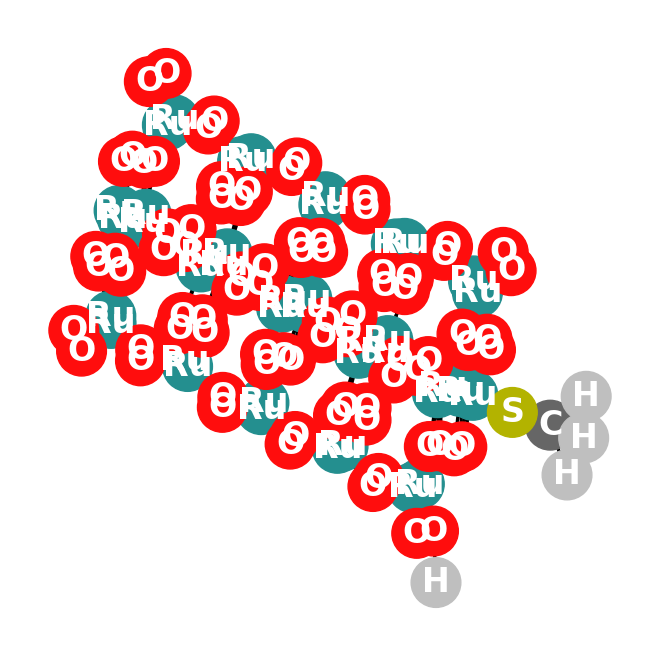

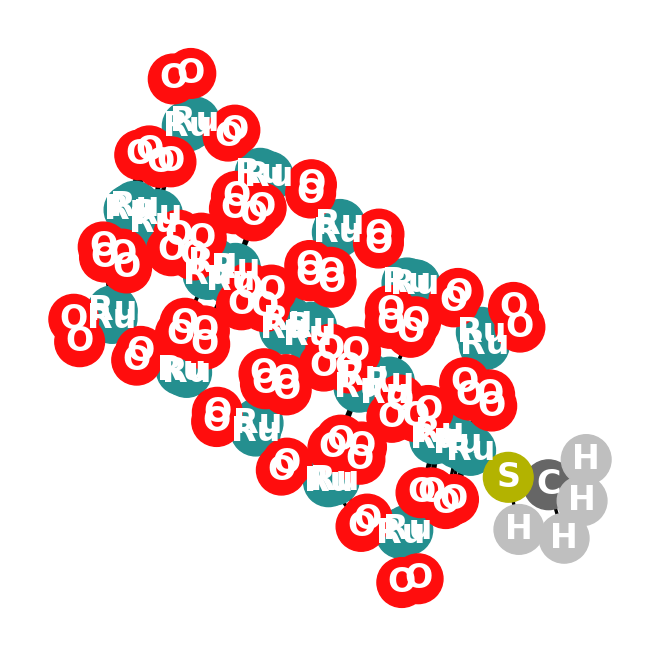

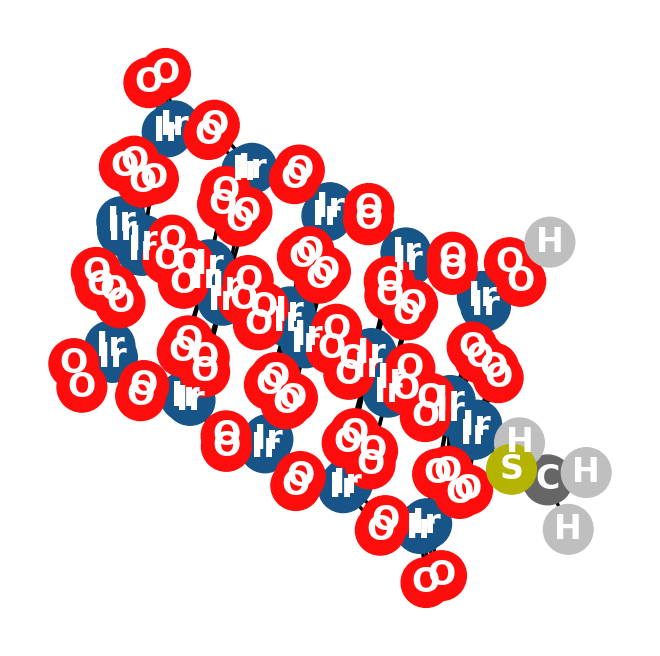

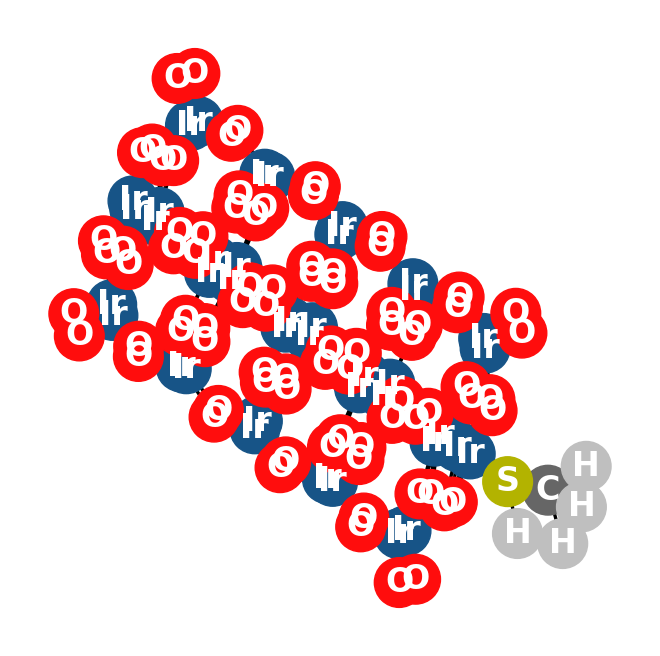

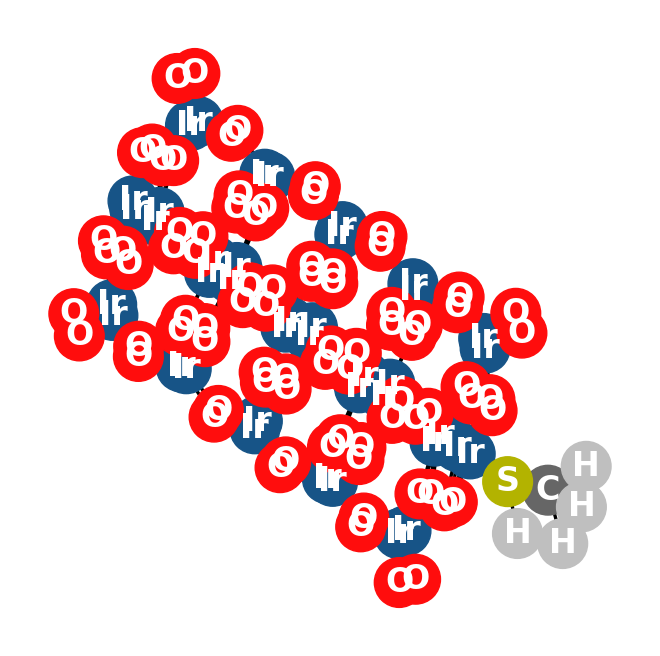

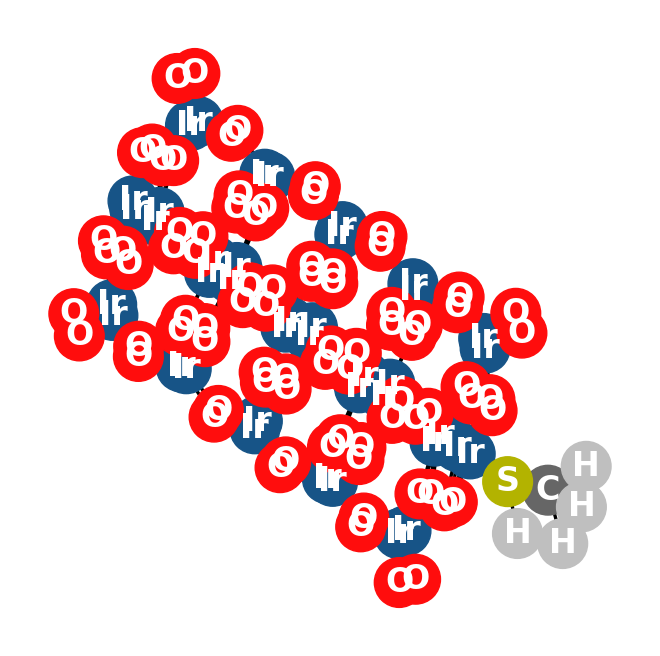

In [ ]:
for graph in dataset:
    graph_plotter(graph, node_index=False)